In [ ]:
#установка необходимых библиотек
!pip install -q spacy natasha nltk scikit-learn transformers datasets wordcloud pillow
!pip install -U transformers
#загрузка модели SpaCy для русского языка
!python -m spacy download ru_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 MB 18.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from natasha import Segmenter, MorphVocab, Doc, NewsEmbedding, NewsMorphTagger
from wordcloud import WordCloud
from PIL import Image

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

# ***Загрузка и объединение данных***


In [ ]:
# #загрузка CSV-файлов
df = pd.read_csv("/content/321.csv")

# ***Разметка sentiment***


In [ ]:
#определение известных категорий
known_categories = [
    "Нравится качество выполнения заявки",
    "Нравится качество работы сотрудников",
    "Нравится скорость отработки заявок",
    "Понравилось выполнение заявки",
    "Вопрос решен"
]


In [ ]:
#добавление колонок для категорий и "Другое"
for col in known_categories + ["Другое"]:
    df[col] = 0

In [ ]:
#обработка столбца 'sentiment'
df["sentiment"] = df["sentiment"].fillna("")

for i, row in df.iterrows():
    try:
        sentiment_data = json.loads(row["sentiment"])
        choices = sentiment_data.get("choices", [])
        for col in known_categories + ["Другое"]:
            df.at[i, col] = 0  # Обнуляем значения
        for choice in choices:
            if choice in known_categories:
                df.at[i, choice] = 1
            else:
                df.at[i, "Другое"] = 1
    except Exception:
        for col in known_categories + ["Другое"]:
            df.at[i, col] = 0


# ***Сравнение по ID с разметкой***


In [ ]:
#загрузка базового файла с разметкой без обработки
df_base = pd.read_csv("/content/разметка комментариев 2.csv")
df_other = df

In [ ]:
#сопоставление по 'id'
if 'id' in df_base.columns and 'id' in df_other.columns:
    df_matched = df_other[df_other['id'].isin(df_base['id'])].reset_index(drop=True)
    df_matched.index += 1  # Индексация с 1
    df_matched.to_csv("/content/комментарии.csv", index=True)
    print("Файл комментарии.csv сохранён успешно.")
else:
    print("В одном из файлов отсутствует колонка 'id'.")


Файл комментарии.csv сохранён успешно.


# ***Предобработка данных***


In [ ]:
#информация о DataFrame
print("\n=== Информация о DataFrame (с дубликатами) ===")
print(f"Общее количество строк: {len(df_matched)}")
print(f"Количество уникальных строк: {len(df_matched.drop_duplicates())}")
print(f"Количество полных дубликатов: {len(df_matched) - len(df_matched.drop_duplicates())}")
print("\n=== Типы данных и пропуски: ===")
print(df_matched.info())


=== Информация о DataFrame (с дубликатами) ===
Общее количество строк: 2368
Количество уникальных строк: 2368
Количество полных дубликатов: 0

=== Типы данных и пропуски: ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2368 entries, 1 to 2368
Data columns (total 15 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   annotation_id                         2368 non-null   int64  
 1   annotator                             2368 non-null   int64  
 2   comment                               2368 non-null   object 
 3   created_at                            2368 non-null   object 
 4   id                                    2368 non-null   int64  
 5   lead_time                             2368 non-null   float64
 6   rating                                2368 non-null   int64  
 7   sentiment                             2368 non-null   object 
 8   updated_at                            2368

In [ ]:
#удаление пропусков
df_matched = df_matched.dropna()

#удаление ненужных колонок
df_clean = df_matched.drop(columns=['annotation_id', 'annotator', 'id', 'updated_at', 'lead_time', 'sentiment', 'created_at'])

#информация о очищенном DataFrame
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2368 entries, 1 to 2368
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   comment                               2368 non-null   object
 1   rating                                2368 non-null   int64 
 2   Вопрос решен                          2368 non-null   int64 
 3   Нравится качество выполнения заявки   2368 non-null   int64 
 4   Нравится качество работы сотрудников  2368 non-null   int64 
 5   Нравится скорость отработки заявок    2368 non-null   int64 
 6   Понравилось выполнение заявки         2368 non-null   int64 
 7   Другое                                2368 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 148.1+ KB


In [ ]:
df_clean['Другое'].value_counts()

,count
Другое,
0,2309
1,59


# ***Визуализация данных***


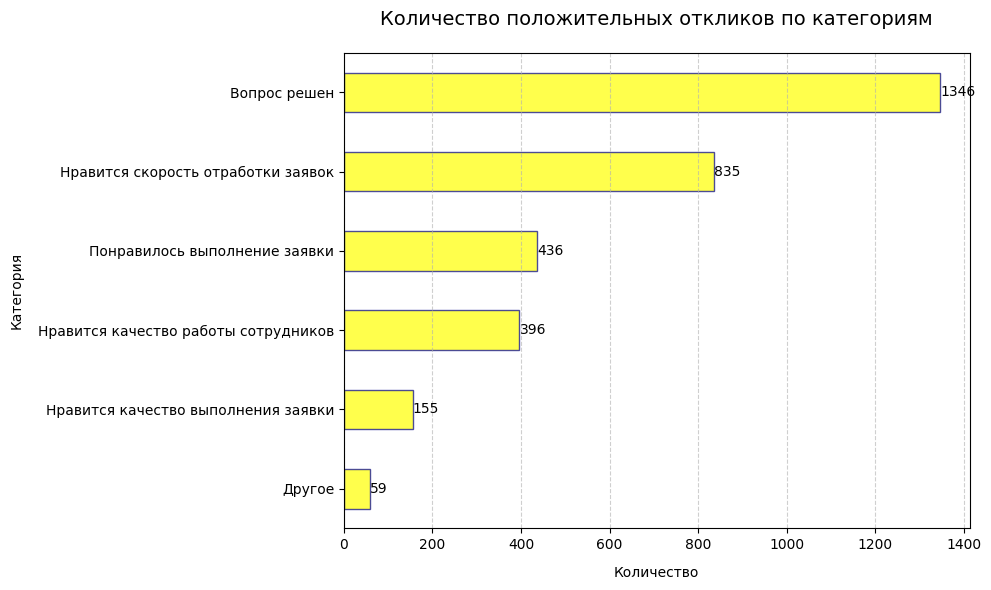

In [ ]:
#определение категорий для анализа
exclude_cols = ['comment', 'id', 'rating', 'sentiment']
category_cols = [col for col in df_clean.columns if col not in exclude_cols]

#построение горизонтальной гистограммы
plt.figure(figsize=(10, 6))
df_clean[category_cols].sum().sort_values().plot(
    kind='barh',
    color='yellow',
    edgecolor='darkblue',
    alpha=0.7
)

#добавление подписей к столбцам
for i, v in enumerate(df_clean[category_cols].sum().sort_values()):
    plt.text(v + 0.5, i, str(v), color='black', va='center')

#настройка оформления графика
plt.title("Количество положительных откликов по категориям", pad=20, fontsize=14)
plt.xlabel("Количество", labelpad=10)
plt.ylabel("Категория", labelpad=10)
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()





In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

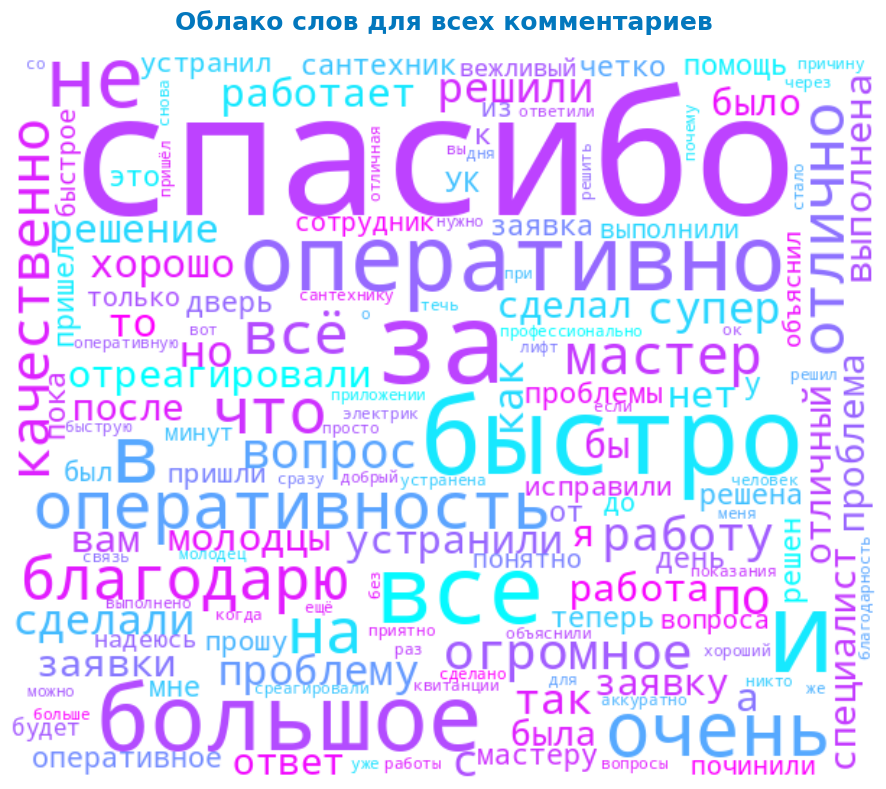

In [ ]:
#улучшенная функция для создания облака слов с заданными цветами
def generate_wordcloud(texts, title):
    # Объединяем все тексты
    all_text = ' '.join(str(text) for text in texts)


#создаем облако слов с указанными параметрами
    wordcloud = WordCloud(
        width=600,
        height=500,
        background_color='white',
        colormap='cool',  #задаем цветовую схему 'cool'
        max_words=150,
        collocations=False,
        min_font_size=10,
        max_font_size=120,
        random_state=42
    ).generate(all_text)

    #настраиваем отображение
    plt.figure(figsize=(14, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

    #задаем цвет заголовка #0277bd
    plt.title(title,
              pad=20,
              fontsize=18,
              fontweight='bold',
              color='#0277bd')  #синий цвет для заголовка

    plt.tight_layout()
    plt.show()

#создаем облако слов для всех комментариев
generate_wordcloud(df_clean['comment'], "Облако слов для всех комментариев")



# ***Обработка текста с Natasha***


In [ ]:
from wordcloud import WordCloud
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#инициализация компонентов Natasha
segmenter = Segmenter()
morph_vocab = MorphVocab()
embeddings = NewsEmbedding()
morph_tagger = NewsMorphTagger(embeddings)

#функция для очистки текста
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\r\n|\n|\r', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Применение очистки текста
df_clean['comment_clean'] = df_clean['comment'].apply(clean_text)

# Функция для лемматизации текста
def lemmatize_text(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    lemmas = [token.lemma for token in doc.tokens]
    return ' '.join(lemmas)

# Применение лемматизации
df_clean['comment_lemma'] = df_clean['comment_clean'].apply(lemmatize_text)

# ***Подготовка данных для обучения модели***


In [ ]:
#загрузка токенизатора
model_name = 'DeepPavlov/rubert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

#токенизация комментариев
encodings = tokenizer(
    df_clean['comment_lemma'].tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors='pt'
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# Подготовка меток
label_columns = [
    'Вопрос решен',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Нравится скорость отработки заявок',
    'Понравилось выполнение заявки',
    'Другое'
]
labels = torch.tensor(df_clean[label_columns].values).float()

# Создание кастомного Dataset
class CommentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Инициализация Dataset
dataset = CommentDataset(encodings, labels)

# ***Обучение модели***

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [ ]:
#установка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#загрузка модели
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_columns),
    problem_type="multi_label_classification"
).to(device)  # <-- переносим модель на device

#настройки обучения
training_args = TrainingArguments(
    output_dir="./sentiment_results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=1,
    report_to="none"  # отключаем W&B
)

#деление на обучающую и тестовую выборки
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

#инициализация Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

#ибучение модели
trainer.train()

#сохранение модели
model.save_pretrained("./sentiment_model")
tokenizer.save_pretrained("./sentiment_model")

#функция предсказания
def predict(texts):
    cleaned = [clean_text(t) for t in texts]
    lemmatized = [lemmatize_text(t) for t in cleaned]
    tokens = tokenizer(lemmatized, padding=True, truncation=True, return_tensors="pt", max_length=128)

#переносим входы на устройство
    tokens = {key: val.to(device) for key, val in tokens.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**tokens)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()  # возвращаем на CPU перед numpy

    predictions = (probs > 0.5).astype(int)
    return predictions, probs

#предсказания
all_preds, all_probs = predict(df_clean['comment'].tolist())

#сохраняем предсказания в DataFrame
for i, col in enumerate(label_columns):
    df_clean[f'pred_{col}'] = all_preds[:, i]
    df_clean[f'prob_{col}'] = all_probs[:, i]

#сохраняем в CSV
df_clean.to_csv("/content/predicted_comments.csv", index=False)
print("Предсказания сохранены в predicted_comments.csv")

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.514600
100,0.327100
150,0.267600
200,0.231800
250,0.205200
300,0.188800
350,0.179500
400,0.176000
450,0.173800
500,0.162300


Предсказания сохранены в predicted_comments.csv


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

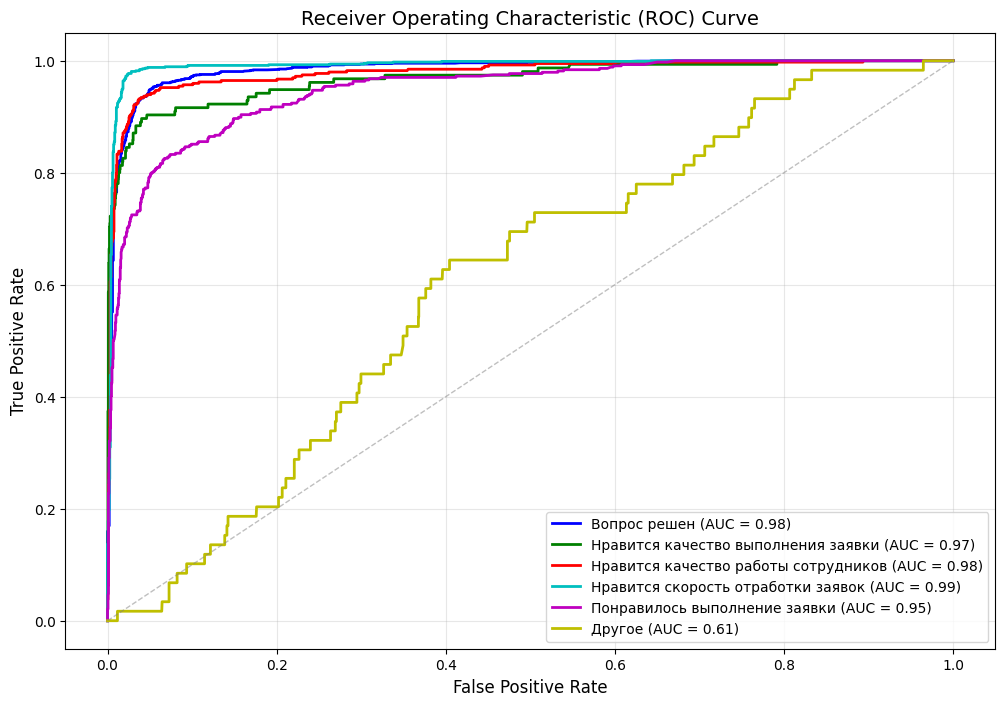

Средний ROC AUC: 0.91
Accuracy: 0.49
Precision: 0.17
Recall: 0.26
F1 Score: 0.12


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def compute_roc_auc(true_labels, predicted_probs, label_columns):
    fpr = {}
    tpr = {}
    roc_auc = {}

    # Стили и цвета для разных кривых
    line_styles = ['-', '-', '-', '-']
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    plt.figure(figsize=(12, 8))

    # Для каждой метки вычисляем fpr, tpr и auc
    for i, label in enumerate(label_columns):
        fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        # Выбираем стиль и цвет для текущей кривой
        style = line_styles[i % len(line_styles)]
        color = colors[i % len(colors)]

        plt.plot(fpr[i], tpr[i],
                linestyle=style,
                color=color,
                lw=2,
                label=f'{label} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1, alpha=0.5)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.show()

    return roc_auc

# Остальной код остается без изменений
true_labels = df_clean[label_columns].values
predicted_probs = all_probs

# Рассчитываем и отображаем ROC AUC для всех меток
roc_auc = compute_roc_auc(true_labels, predicted_probs, label_columns)

# Среднее значение ROC AUC
avg_roc_auc = np.mean(list(roc_auc.values()))
print(f'Средний ROC AUC: {avg_roc_auc:.2f}')

# Метрики классификации
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

predicted_classes = np.argmax(predicted_probs, axis=1)
true_classes = np.argmax(true_labels, axis=1)

accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")